In [149]:
import numpy as np
from scipy.linalg import dft
import matplotlib.pyplot as plt

In [150]:
M = 64 # symbols per frame
N = 8 # modulation order
number_of_frames = 100
modulation_order = 4 # bits per symbol
snr_db = list(range(-20, 21, 2))
ber = []
# Plot pair list
snr_ber = []
# Channel generation
tau = [0, 1, 2, 3]
mu = [0, 1, 2, 3]

In [151]:
# Generate 4 random complex numbers with unit amplitude
phase_angles = np.random.uniform(0, 2 * np.pi, 4)  # Random phases between 0 and 2π
complex_numbers = (1/np.sqrt(2)) * np.exp(1j * phase_angles)  # Convert to complex form

# Reshape into a 1x4 numpy array
h = complex_numbers.reshape(1, 4)
h = h.flatten()

In [152]:
def qam4_modulate(bits):
    """
    4-QAM modulation: Maps 2-bit pairs to QAM symbols.

    Parameters:
    bits (numpy array): 1D binary array (length should be even)

    Returns:
    numpy array: Complex symbols representing QAM modulation
    """
    if len(bits) % 2 != 0:
        raise ValueError("Input length must be even for 4-QAM modulation.")

    bit_pairs = bits.reshape(-1, 2)  # Reshape into pairs
    symbol_map = {
        (0, 0):  1+1j,  # 00 -> (1,1)
        (0, 1):  1-1j,  # 01 -> (1,-1)
        (1, 0): -1+1j,  # 10 -> (-1,1)
        (1, 1): -1-1j   # 11 -> (-1,-1)
    }
    
    symbols = np.array([symbol_map[tuple(pair)] for pair in bit_pairs])
    return symbols

def qam4_demodulate(symbols):
    """
    4-QAM demodulation: Maps QAM symbols back to binary sequence.

    Parameters:
    symbols (numpy array): Complex-valued matrix received from QAM modulation

    Returns:
    numpy array: 2D binary array (same shape as input but with each element mapped to 2 bits)
    """
    decision_map = {
        1+1j: [0, 0],  # 00
        1-1j: [0, 1],  # 01
        -1+1j: [1, 0],  # 10
        -1-1j: [1, 1]   # 11
    }
    
    # Vectorized processing of each symbol in the input matrix
    demodulated_bits = np.zeros((symbols.shape[0], symbols.shape[1] * 2), dtype=int)
    
    for i in range(symbols.shape[0]):
        for j in range(symbols.shape[1]):
            symbol = symbols[i, j]
            closest_point = min(decision_map.keys(), key=lambda x: abs(x - symbol))
            demodulated_bits[i, 2*j:2*j+2] = decision_map[closest_point]
    
    return demodulated_bits

def generate_complex_gaussian_matrix(rows, cols, sigma):
    """
    Generates a matrix of complex Gaussian random numbers.

    Parameters:
    - rows (int): Number of rows.
    - cols (int): Number of columns.
    - sigma (float): Standard deviation (square root of variance).

    Returns:
    - numpy.ndarray: (rows, cols) matrix of complex Gaussian numbers.
    """
    real_part = np.random.normal(0, sigma / np.sqrt(2), (rows, cols))  # Real part ~ N(0, sigma^2/2)
    imag_part = np.random.normal(0, sigma / np.sqrt(2), (rows, cols))  # Imaginary part ~ N(0, sigma^2/2)

    complex_matrix = real_part + 1j * imag_part
    return complex_matrix

def dft_matrix(N):
    """
    Generates an N x N Discrete Fourier Transform (DFT) matrix.

    Parameters:
    N (int): Size of the DFT matrix.

    Returns:
    numpy.ndarray: N x N DFT matrix.
    """
    n = np.arange(N)
    k = n.reshape((N, 1))
    omega = np.exp(-2j * np.pi * k * n / N)  # DFT formula
    return omega

In [153]:
binary_sequence = np.random.randint(0, 2, size=M*N)

In [154]:
binary_matrix = binary_sequence.reshape(M, N)
qam4_symbols = qam4_modulate(bits=binary_matrix)
I = np.eye(M)
dft = dft_matrix(N=N//2)
p_Signal = 1
pi = np.roll(np.eye(M * N//2), shift=1)
# Define the diagonal elements
i_values = np.arange(M * N//2)  # i ranges from 0 to 255
diagonal_elements = np.exp(1j * i_values * 2 * np.pi / M)  # e^(i*j*2*pi/64)
# Create a diagonal matrix using np.diag()
delta = np.diag(diagonal_elements)
H = np.matmul(np.roll(pi, shift=0), np.linalg.matrix_power(delta, 0))
H = H * h[0]
for j in range(1, N//2):
    H = np.add(np.matmul(np.roll(pi, j), np.linalg.matrix_power(delta, j)), H * h[j])
H_eff = np.matmul(np.matmul(np.kron(dft, I), H), np.kron(np.conj(dft), I))
qam4_symbols_reshaped = qam4_symbols.reshape(M * N//2, 1)
for i in snr_db:
    tot_errors = 0
    for epoch in range(0, 100):
        sigma = np.sqrt((10**(-i/10)) * p_Signal)
        complex_gaussian_matrix = generate_complex_gaussian_matrix(M, N//2, sigma)
        complex_gaussian_matrix_reshaped = complex_gaussian_matrix.reshape(M * N//2, 1)
        w_tilde = np.matmul(np.kron(dft, I), complex_gaussian_matrix_reshaped)
        y = (H_eff @ qam4_symbols_reshaped) + w_tilde
        x_cap = np.matmul(np.linalg.inv(H_eff), y)
        x_cap_demodulated = qam4_demodulate(x_cap)
        x_cap_demodulated_reshaped = x_cap_demodulated.reshape(M * N, 1)
        errors:int = 0
        for j in range(len(x_cap_demodulated_reshaped)):
            if (x_cap_demodulated_reshaped[j] != binary_sequence[j]):
                errors += 1
        tot_errors += errors
        print(f"i = {i}, epoch = {epoch}, errors = {errors}")
    average_error = tot_errors/100
    snr_ber.append((i, average_error/(M*N))) 

i = -20, epoch = 0, errors = 204
i = -20, epoch = 1, errors = 210
i = -20, epoch = 2, errors = 210
i = -20, epoch = 3, errors = 199
i = -20, epoch = 4, errors = 218
i = -20, epoch = 5, errors = 201
i = -20, epoch = 6, errors = 223
i = -20, epoch = 7, errors = 228
i = -20, epoch = 8, errors = 220
i = -20, epoch = 9, errors = 210
i = -20, epoch = 10, errors = 223
i = -20, epoch = 11, errors = 218
i = -20, epoch = 12, errors = 226
i = -20, epoch = 13, errors = 196
i = -20, epoch = 14, errors = 220
i = -20, epoch = 15, errors = 221
i = -20, epoch = 16, errors = 207
i = -20, epoch = 17, errors = 214
i = -20, epoch = 18, errors = 208
i = -20, epoch = 19, errors = 225
i = -20, epoch = 20, errors = 220
i = -20, epoch = 21, errors = 222
i = -20, epoch = 22, errors = 243
i = -20, epoch = 23, errors = 212
i = -20, epoch = 24, errors = 222
i = -20, epoch = 25, errors = 216
i = -20, epoch = 26, errors = 214
i = -20, epoch = 27, errors = 219
i = -20, epoch = 28, errors = 224
i = -20, epoch = 29, err

In [155]:
print(snr_ber)

[(-20, 0.42484375), (-18, 0.40712890625), (-16, 0.38625), (-14, 0.35669921875), (-12, 0.32203125), (-10, 0.27568359375), (-8, 0.23083984375), (-6, 0.178125), (-4, 0.1216796875), (-2, 0.07193359375), (0, 0.03345703125), (2, 0.01005859375), (4, 0.00138671875), (6, 0.00013671875), (8, 1.953125e-05), (10, 0.0), (12, 0.0), (14, 0.0), (16, 0.0), (18, 0.0), (20, 0.0)]


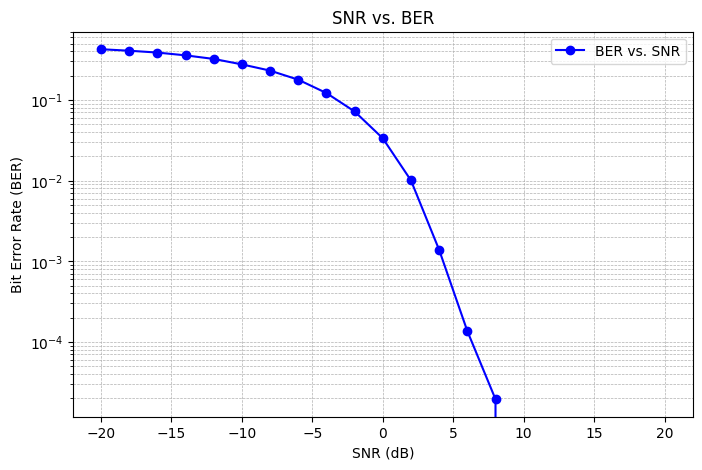

In [156]:
# Extract SNR (x-axis) and BER (y-axis)
snr_values, ber_values = zip(*snr_ber)

# Plot the graph
plt.figure(figsize=(8, 5))
plt.plot(snr_values, ber_values, marker='o', linestyle='-', color='b', label="BER vs. SNR")

# Log scale for BER axis (since BER values are very small)
plt.yscale("log")

# Labels and title
plt.xlabel("SNR (dB)")
plt.ylabel("Bit Error Rate (BER)")
plt.title("SNR vs. BER")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.legend()

# Show the plot
plt.show()